In [1]:
import os

# Let's retrieve last results report
res_dir = os.path.join("results")

results_file = os.path.join(res_dir,"results_history.json")
if os.path.exists(results_file):
    os.remove(results_file)

result = os.system(f"scp pmartinello@aimagelab-srv-login.ing.unimore.it:/work/cvcs_2022_group02/results/results_history.json {res_dir}")
if result == 0:
    print("Results history has been correctly retrieved from server.")
else:
    print("Results history has not been retrieved :(")

Results history has been correctly retrieved from server.


In [2]:
import torch
import numpy as np
import json
import math

os.environ["KMP_DUPLICATE_LIB_OK"]='True'   # I've problem with plt and this resolves.
from matplotlib import pyplot as plt

f = open(results_file)
results_history = json.load(f)

test_every_n_epochs = 2
metrics_x_axis = [i * test_every_n_epochs for i in range(0,len(results_history['mAP']))]
#print(metrics_x_axis)

save_graphics = False

### Generate Loss functions graphics

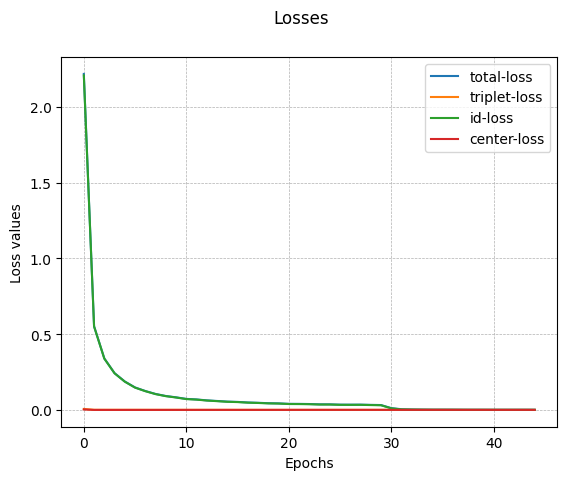

In [3]:
fig, ax = plt.subplots(1,1)
fig.suptitle("Losses")

for k in results_history.keys():
    if not k.endswith("loss"):    
        continue
    ax.plot(results_history[k], label=k)
ax.legend(loc='upper right')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss values")
ax.set_yscale("linear")
plt.grid(linestyle = '--', linewidth = 0.5)
if save_graphics:
    plt.savefig(os.path.join(res_dir, "losses_graph.jpg"))
plt.show()

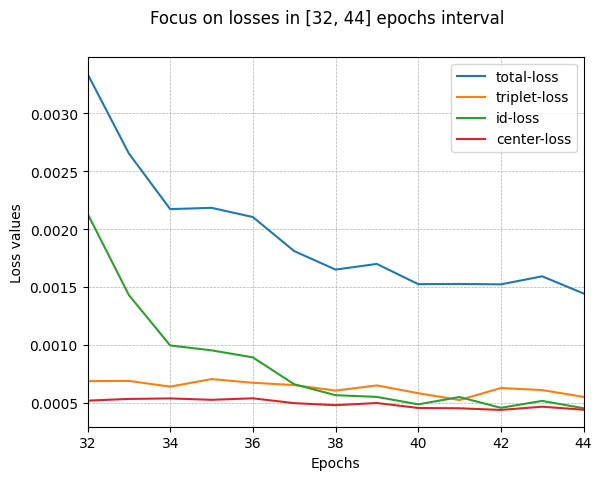

In [10]:
# In case you want a plot of losses limited to an interval of epochs:

# to be set following your preferences
min_epoch = 32  # inclusive, -1 means no bound
max_epoch = -1  # inclusive, -1 means no bound




total_loss_data = results_history['total-loss']
if min_epoch < 0:
    min_epoch = 0
if max_epoch < 0:
    max_epoch = len(total_loss_data)
else:
    max_epoch +=1
x_range = [i for i in range(min_epoch, max_epoch)]
fig, ax = plt.subplots(1,1)
fig.suptitle(f"Focus on losses in [{min_epoch}, {max_epoch-1}] epochs interval")

for k in results_history.keys():
    if not k.endswith("loss"):    
        continue
    ax.plot(x_range, results_history[k][min_epoch:max_epoch], label=k)
ax.legend(loc='upper right')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss values")
ax.set_yscale("linear")
ax.set_xlim((min_epoch, max_epoch-1))
plt.grid(linestyle = '--', linewidth = 0.5)
if save_graphics:
    plt.savefig(os.path.join(res_dir, "losses_graph_focus.jpg"))
plt.show()

### Generate mAP function graphics

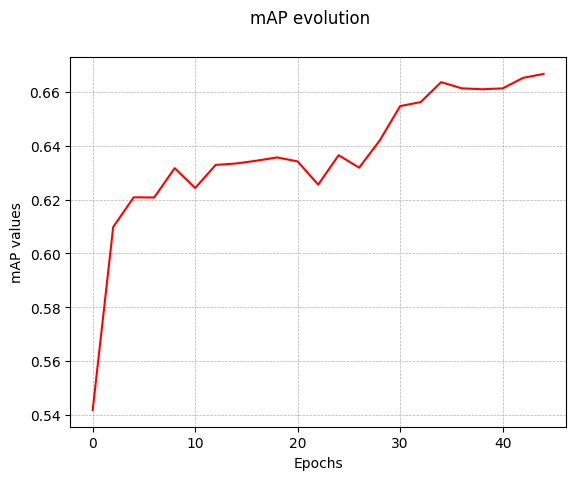

In [5]:
metric_history = results_history['mAP']
fig, ax = plt.subplots(1,1)
fig.suptitle("mAP evolution")
ax.plot(metrics_x_axis, metric_history, 'r-', label='mAP')
ax.set_xlabel("Epochs")
ax.set_ylabel("mAP values")
ax.set_yscale("linear")
plt.grid(linestyle = '--', linewidth = 0.5)
#plt.xticks(np.arange(0, len(metric_history), 2))
if save_graphics:
    plt.savefig(os.path.join(res_dir, "mAP_graph.jpg"))
plt.show()

### Generate mINP function graphics

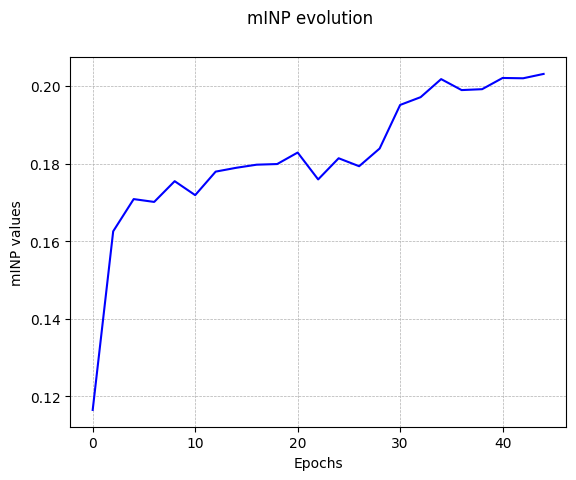

In [6]:
metric_history = results_history['mINP']
fig, ax = plt.subplots(1,1)
fig.suptitle("mINP evolution")
ax.plot(metrics_x_axis, metric_history, 'b-', label='mINP')
ax.set_xlabel("Epochs")
ax.set_ylabel("mINP values")
ax.set_yscale("linear")
plt.grid(linestyle = '--', linewidth = 0.5)
#plt.xticks(np.arange(0, len(metric_history), 2))
if save_graphics:
    plt.savefig(os.path.join(res_dir, "mINP_graph.jpg"))
plt.show()

### Generate CMC functions graphics

In [7]:
# let's say we don't know how many and which rank-n metrics there will be in the json file, nor the order.
# this will format these metrics properly.

first_done = False
for k in results_history.keys():
    if not k.startswith("rank"):
        continue
    n = int(k.split('-')[-1])
    if not first_done:
        ranks = torch.tensor(n).unsqueeze(0).to(dtype=torch.int)
        cmcs = torch.tensor(results_history[k]).unsqueeze(0).to(dtype=torch.float)
        first_done = True
    else:
        ranks = torch.cat((ranks, torch.tensor(n).unsqueeze(0).to(dtype=torch.int)))
        cmcs = torch.cat((cmcs,torch.tensor(results_history[k]).unsqueeze(0).to(dtype=torch.float)))

cmcs = cmcs * 100.0     #we want cmc expressed in %
idx = torch.argsort(ranks)
ranks = ranks.index_select(0, idx)
cmcs = cmcs.index_select(0,idx)
ranks = [i.item() for i in ranks]
labels = [f"rank-{i}" for i in ranks]
print(cmcs.shape)
print(ranks)
print(labels)


torch.Size([6, 23])
[1, 2, 5, 10, 15, 20]
['rank-1', 'rank-2', 'rank-5', 'rank-10', 'rank-15', 'rank-20']


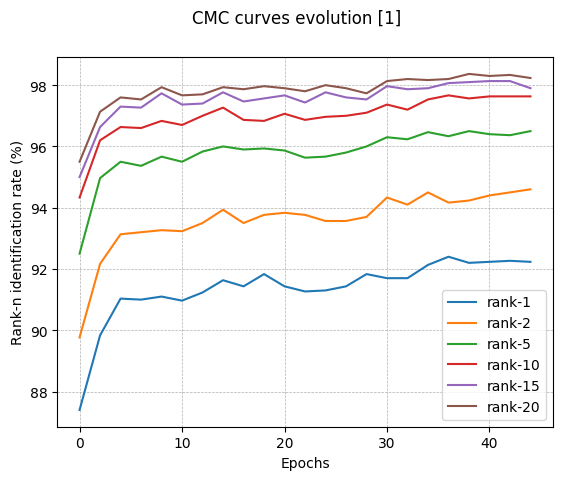

In [8]:
fig, ax = plt.subplots(1,1)
fig.suptitle("CMC curves evolution [1]")

for (idx, name) in enumerate(labels):
    ax.plot(metrics_x_axis, cmcs[idx], label=name)

ax.legend(loc='lower right')
ax.set_xlabel("Epochs")
ax.set_ylabel("Rank-n identification rate (%)")
ax.set_yscale("linear")
plt.grid(linestyle = '--', linewidth = 0.5)
#plt.xticks(np.arange(0, cmcs.shape[1], 2))
if save_graphics:
    plt.savefig(os.path.join(res_dir, "cmcs_over_epochs_graph.jpg"))
plt.show()

11.0


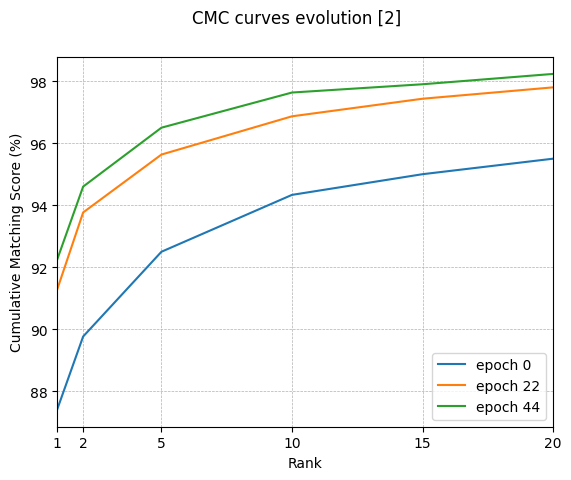

In [9]:
# to be set following your preferences
curves_to_display = 3




interval = (cmcs.shape[1]-1)/ (curves_to_display-1)
print(interval)
cum_data = torch.zeros(size=(curves_to_display, cmcs.shape[0]),dtype=torch.float)
#for sure we want the first and the last epoch data.
cum_data[0] = cmcs[:,0]
labels = []
labels.append(f"epoch 0")

for i in range(1, max(0,curves_to_display-1)):
    target_epoch = round(i*interval)
    cum_data[i] = cmcs[:, target_epoch]
    labels.append(f"epoch {target_epoch * test_every_n_epochs}")

cum_data[-1] = cmcs[:,-1]
labels.append(f"epoch {(cmcs.shape[1] -1)* test_every_n_epochs}")



fig, ax = plt.subplots(1,1)
fig.suptitle("CMC curves evolution [2]")
for i in range(cum_data.shape[0]):
    ax.plot(ranks, cum_data[i], label=labels[i])

ax.legend(loc='lower right')
ax.set_xlabel("Rank")
ax.set_ylabel("Cumulative Matching Score (%)")
ax.set_xscale("linear")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xticks(ranks)
ax.set_xlim(1, ranks[-1])

if save_graphics:
    plt.savefig(os.path.join(res_dir, "cmcs_over_rank_graph.jpg"))
plt.show()